# Solutions for homework 3

The first 3 cells contains all implementations and the next cells answer the questions in order.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [314]:
def relu(x):
    return (x > 0) * x

def softmax(x, axis=1):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)

def onehot(y, n_classes):
    o = np.zeros(shape=(y.shape[0], n_classes))
    for i in range(y.shape[0]):
        o[i, int(y[i])] = 1
    return o

In [280]:
class MLP:
    
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.uniform(-input_size**-.5, input_size**-.5, size=(hidden_size, input_size))
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.uniform(-hidden_size**-.5, hidden_size**-.5, size=(output_size, hidden_size))
        self.b2 = np.zeros(output_size)
        self.parameters = [self.b1, self.W1, self.b2, self.W2]
        
    def loop_fprop(self, x):
        ha = np.dot(self.W1, x) + self.b1
        hs = relu(ha)
        oa = np.dot(self.W2, hs) + self.b2
        os = softmax(oa, axis=0)
        return ha, hs, oa, os
        
    def loop_bprop(self, y, x, ha, hs, oa, os, weight_decay=0):
        dl_doa = os - y
        dl_dhs = np.dot(self.W2.T, dl_doa)
        dl_dha = (ha > 0) * dl_dhs
        dl_dW2 = np.outer(dl_doa, hs) + weight_decay * self.W2
        dl_db2 = dl_doa
        dl_dW1 = np.outer(dl_dha, x) + weight_decay * self.W1
        dl_db1 = dl_dha
        return dl_db1, dl_dW1, dl_db2, dl_dW2
    
    def loop_loss(self, os, y):
        return (y * (-np.log(os))).sum()
    
    def loop_finite_diff(self, x, y, eps=1e-5):
        ha, hs, oa, os = self.loop_fprop(x)
        gradients_bprop = self.loop_bprop(y, x, ha, hs, oa, os)
        loss = self.loop_loss(os, y)
        gradients_finite_diff = []
        for p in self.parameters:
            grad_fdiff = np.zeros(shape=p.shape)
            for index, v in np.ndenumerate(p):
                p[index] += eps
                _, _, _, os = self.loop_fprop(x)
                loss_diff = self.loop_loss(os, y)
                grad_fdiff[index] = (loss_diff - loss) / eps
                p[index] -= eps
            gradients_finite_diff.append(grad_fdiff)
        return gradients_finite_diff
    
    def loop_train(self, data, target, mb_size=100, learning_rate=1e-1, weight_decay=0.):
        for i in range(data.shape[0] // mb_size):
            xi = data[i*mb_size:(i+1)*mb_size]
            yi = target[i*mb_size:(i+1)*mb_size]
            ha, hs, oa, os = self.mat_fprop(xi)
            average_loss, average_grads = self.loop_grad(xi, yi, weight_decay)
            for p, grad in zip(self.parameters, average_grads):
                p -= learning_rate * grad
        return average_loss
    
    def loop_grad(self, x, y, weight_decay=0):
        sum_grads = [np.zeros(shape=p.shape) for p in self.parameters]
        sum_loss = 0
        for xi, yi in zip(x, y):
            ha, hs, oa, os = self.loop_fprop(xi)
            grad = self.loop_bprop(yi, xi, ha, hs, oa, os, weight_decay)
            sum_grads = [g1 + g2 for g1, g2 in zip(grad, sum_grads)]
            sum_loss += self.loop_loss(os, yi)
        average_grads = [g / x.shape[0] for g in sum_grads]
        return sum_loss / x.shape[0], average_grads
            
    def loop_predict(self, x):
        predictions = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            xi = x[i]
            _, _, _, os = self.loop_fprop(xi)
            predictions[i] = os.argmax()
        return predictions
    
    def mat_fprop(self, x):
        ha = np.dot(x, self.W1.T) + self.b1
        hs = relu(ha)
        oa = np.dot(hs, self.W2.T) + self.b2
        os = softmax(oa, axis=1)
        return ha, hs, oa, os
    
    def mat_bprop(self, y, x, ha, hs, oa, os, weight_decay=0):
        bs = x.shape[0]
        dl_doa = os - y
        dl_dhs = np.dot(dl_doa, self.W2)
        dl_dha = (ha > 0) * dl_dhs
        dl_dW2 = np.dot(dl_doa.T, hs) / bs + weight_decay * self.W2
        dl_db2 = dl_doa.mean(axis=0)
        dl_dW1 = np.dot(dl_dha.T, x) / bs + weight_decay * self.W1
        dl_db1 = dl_dha.mean(axis=0)
        return dl_db1, dl_dW1, dl_db2, dl_dW2
    
    def mat_loss(self, os, y):
        return (y * (-np.log(os))).sum(axis=1).mean(axis=0)            
        
    def mat_train(self, data, target, mb_size=100, learning_rate=1e-1, weight_decay=0.):
        for i in range(data.shape[0] // mb_size):
            xi = data[i*mb_size:(i+1)*mb_size]
            yi = target[i*mb_size:(i+1)*mb_size]
            ha, hs, oa, os = self.mat_fprop(xi)
            average_grads = self.mat_bprop(yi, xi, ha, hs, oa, os, weight_decay)
            average_loss = self.mat_loss(os, yi)
            for p, grad in zip(self.parameters, average_grads):
                p -= learning_rate * grad
        return average_loss
    
    def mat_predict(self, x):
        _, _, _, os = self.mat_fprop(x)
        return os.argmax(axis=1)
    
    def mat_test(self, x, y):
        _, _, _, os = self.mat_fprop(x)
        return self.mat_loss(os, y), os.argmax(axis=1)

### Q1

See methods prefixed with `loop` above: `loop_fprop`, `loop_bprop`, ...

### Q2 Implementation and check that the gradients are correct

In [266]:
# check the gradient using random sample
mlp = MLP(2, 2, 3)
x = np.random.uniform(-1, 1, size=(2, ))
y = np.zeros(shape=(3, ))
y[1] = 1
ha, hs, oa, os = mlp.loop_fprop(x)
print('gradients computed by bprop ', mlp.loop_bprop(y, x, ha, hs, oa, os))
print('gradients finite differences', mlp.loop_finite_diff(x, y))

gradients computed by bprop  (array([ 0.10520514, -0.        ]), array([[-0.01158034,  0.01023195],
       [ 0.        , -0.        ]]), array([ 0.33383033, -0.66991987,  0.33608955]), array([[ 0.03120848, -0.        ],
       [-0.06262816,  0.        ],
       [ 0.03141968, -0.        ]]))
gradients finite differences [array([0.10520517, 0.        ]), array([[-0.01158034,  0.01023195],
       [ 0.        ,  0.        ]]), array([ 0.33383144, -0.66991877,  0.33609066]), array([[ 0.03120849,  0.        ],
       [-0.06262815,  0.        ],
       [ 0.03141969,  0.        ]])]


### Q3

See method `loop_grad`

### Q4 Check the gradients

In [282]:
# check the gradient using random sample
mlp = MLP(2, 2, 3)
x = np.random.uniform(-1, 1, size=(3, 2))
y = np.zeros(shape=(3, 3))
y[0, 1] = 1
y[1, 0] = 1
y[2, 2] = 1
print('gradients computed by bprop ', mlp.loop_grad(x, y)[1])

grad_finitediff = [np.zeros(shape=p.shape) for p in mlp.parameters]
for i in range(3):
    grad_finitediff = [g + g2 / 3 for g, g2 in zip(grad_finitediff, mlp.loop_finite_diff(x[i, :], y[i, :]))]

print('gradients finite differences', grad_finitediff)

gradients computed by bprop  [array([0.00792534, 0.0012467 ]), array([[-0.05264184,  0.0660062 ],
       [ 0.01567731, -0.12947669]]), array([-0.01039936,  0.01715542, -0.00675607]), array([[ 0.01456068, -0.01236512],
       [ 0.05610814,  0.01457899],
       [-0.07066882, -0.00221387]])]
gradients finite differences [array([0.00792565, 0.00124699]), array([[-0.05264175,  0.06600634],
       [ 0.01567739, -0.12947657]]), array([-0.01039826,  0.01715656, -0.00675497]), array([[ 0.01456074, -0.01236511],
       [ 0.05610819,  0.014579  ],
       [-0.07066877, -0.00221386]])]


### Preparation for Q5

In [315]:
data_circles = np.loadtxt(open('circles.txt','r'))
data_circles_target_onehot = onehot(data_circles[:, -1], 2)

def plot_decision(model, axis=None):
    if axis is None:
        axis = plt.gca()
    xx, yy = np.meshgrid(np.arange(-1.1, 1.11, 0.01),
                         np.arange(-1.1, 1.11, 0.01))
    Z = model.loop_predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axis.contourf(xx, yy, Z, 1, alpha=0.8)
    axis.scatter(data_circles[:, 0], data_circles[:, 1], c=data_circles[:, 2])

### Q5: Training on the circles dataset for different hyperparameter values

We gave half the points if one of the plot actually solved the task, and we gave the remaining half points if there was variety in your plots, that show the influence of the hyperparameters.

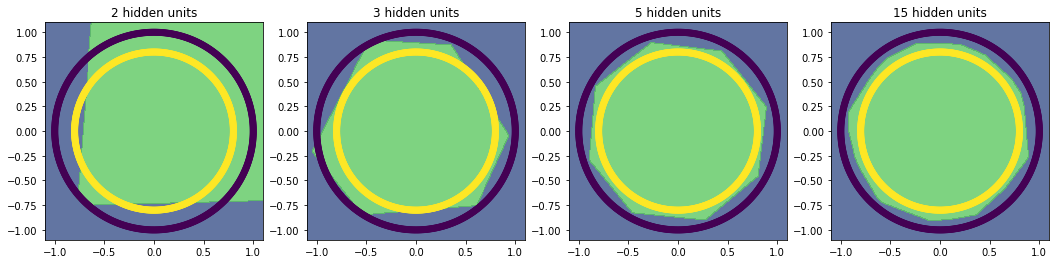

In [316]:
# Effet of number of hidden units
plt.figure(figsize=(18, 4))
for i, n_hidden in enumerate([2, 3, 5, 15]):
    mlp = MLP(2, n_hidden, 2)
    for e in range(50):
        loss = mlp.loop_train(data_circles[:, :2], data_circles_target_onehot, learning_rate=5e-1)
    axis = plt.subplot(1, 4, i+1)
    axis.set_title('%d hidden units' % (n_hidden, ))
    plot_decision(mlp, axis)

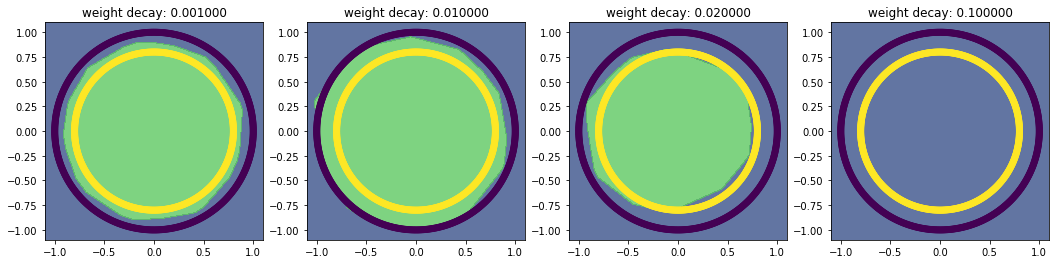

In [303]:
# Effet of weight decay
plt.figure(figsize=(18, 4))
for i, weight_decay in enumerate([1e-3, 1e-2, 2e-2, 1e-1]):
    mlp = MLP(2, 15, 2)
    for e in range(50):
        loss = mlp.loop_train(data_circles[:, :2], data_circles_target_onehot, learning_rate=1e0, weight_decay=weight_decay)
    axis = plt.subplot(1, 4, i+1)
    axis.set_title('weight decay: %f' % (weight_decay, ))
    plot_decision(mlp, axis)

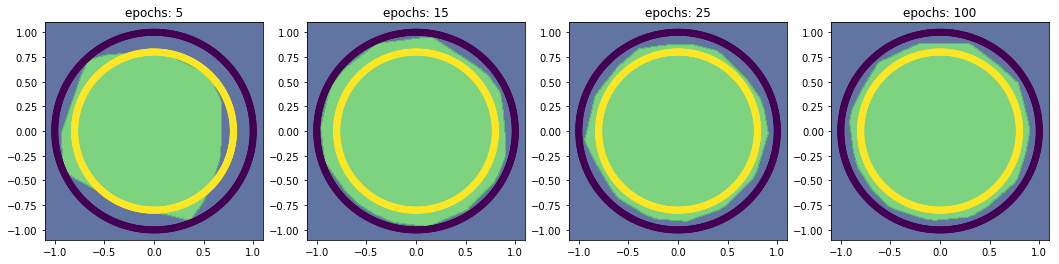

In [304]:
# Effet of weight decay
plt.figure(figsize=(18, 4))
for i, epochs in enumerate([5, 15, 25, 100]):
    mlp = MLP(2, 15, 2)
    for e in range(epochs):
        loss = mlp.loop_train(data_circles[:, :2], data_circles_target_onehot, learning_rate=1e0)
    axis = plt.subplot(1, 4, i+1)
    axis.set_title('epochs: %d' % (epochs, ))
    plot_decision(mlp, axis)

### Q6: Matrix implementation

All methods using matrices are prefixed with mat: `mat_fprop`, `mat_bprop` and so on.
We replaced the linear transformations, and we replaced the way the derivatives are computed. See the implementation for details.

### Q7: Gradients check

In [309]:
# check the gradient using random sample
mlp = MLP(2, 2, 3)
x = np.random.uniform(-1, 1, size=(3, 2))
y = np.zeros(shape=(3, 3))
y[0, 1] = 1
y[1, 0] = 1
y[2, 2] = 1
print('gradients computed by loop bprop ', mlp.loop_grad(x, y)[1])

ha, hs, oa, os = mlp.mat_fprop(x)
average_grads = mlp.mat_bprop(y, x, ha, hs, oa, os)
print('gradients computed by mat bprop ', average_grads)

gradients computed by loop bprop  [array([-0.05946685, -0.00948203]), array([[ 0.02140889, -0.03145497],
       [-0.08591035,  0.10324867]]), array([-0.00916566,  0.00367167,  0.00549399]), array([[ 0.0641273 , -0.01217123],
       [ 0.04974893,  0.01570329],
       [-0.11387623, -0.00353206]])]
gradients computed by mat bprop  (array([-0.05946685, -0.00948203]), array([[ 0.02140889, -0.03145497],
       [-0.08591035,  0.10324867]]), array([-0.00916566,  0.00367167,  0.00549399]), array([[ 0.0641273 , -0.01217123],
       [ 0.04974893,  0.01570329],
       [-0.11387623, -0.00353206]]))


### Preparation for Q8, Q9, Q10: Loading Fashion MNIST

In [321]:
# Either put the fashionmnist folder in the current folder or uncomment the next line that will download it
# !git clone https://github.com/zalandoresearch/fashion-mnist fashionmnist

In [317]:
from fashionmnist.utils import mnist_reader
from random import shuffle

X_train, y_train = mnist_reader.load_mnist('fashionmnist/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('fashionmnist/data/fashion', kind='t10k')

indices = list(range(len(X_train)))
shuffle(indices)

X_train = X_train / 255
X_test = X_test / 255

X_valid, y_valid = X_train[indices[55000:]], y_train[indices[55000:]]
X_train, y_train = X_train[indices[:55000]], y_train[indices[:55000]]

y_train_onehot = onehot(y_train, 10)
y_valid_onehot = onehot(y_valid, 10)
y_test_onehot = onehot(y_test, 10)

### Q8: Timings matrix vs loop

In [318]:
import time
mlp = MLP(784, 100, 10)
start_time = time.time()
mlp.loop_train(X_train, y_train_onehot, mb_size=100)
time_loop = time.time() - start_time

start_time = time.time()
mlp.mat_train(X_train, y_train_onehot, mb_size=100)
time_mat = time.time() - start_time

print('Time with loop implementation: %f seconds\n' % time_loop +
      'Time with mat implementation: %f seconds' % time_mat)

Time with loop implementation: 36.227390 seconds
Time with mat implementation: 1.212487 seconds


### Q9: compute train/valid/test loss and accuracy

We displayed the figures in Q10.
We gave 2.5 points for computing the figures, and 2.5 points if you correctly displayed them in the next question.

In [327]:
mlp = MLP(784, 100, 10)

train_accuracies, train_losses = [], []
valid_accuracies, valid_losses = [], []
test_accuracies, test_losses = [], []

for e in range(50):
    loss = mlp.mat_train(X_train, y_train_onehot, mb_size=100, learning_rate=1e-1)
    
    loss_train, pred_train = mlp.mat_test(X_train, y_train_onehot)
    loss_valid, pred_valid = mlp.mat_test(X_valid, y_valid_onehot)
    loss_test, pred_test = mlp.mat_test(X_test, y_test_onehot)
    valid_losses.append(loss_valid)
    test_losses.append(loss_test)
    valid_accuracies.append((pred_valid == y_valid).mean())
    test_accuracies.append((pred_test == y_test).mean())
    train_losses.append(loss_train)
    train_accuracies.append((pred_train == y_train).mean())

### Q10: display training curves

We gave the points if you obtained less than 20% error. As you see here, you can reach ~88% accuracy on the test set without using any other technique such as dropout, data augmentation, and so on.

Text(0.5,0,'Epochs')

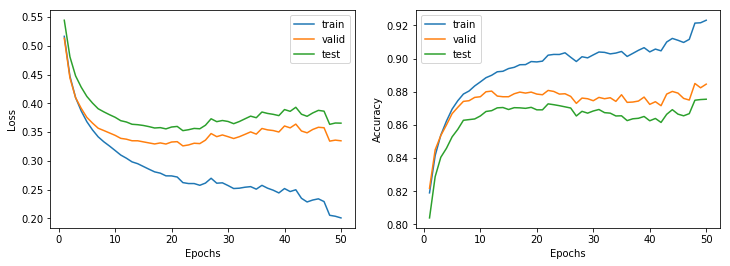

In [328]:
plt.figure(figsize=(12, 4))
axis = plt.subplot(1, 2, 1)
axis.plot(range(1, len(train_losses)+1), train_losses, label='train')
axis.plot(range(1, len(valid_losses)+1), valid_losses, label='valid')
axis.plot(range(1, len(test_losses)+1), test_losses, label='test')
axis.legend()
axis.set_ylabel('Loss')
axis.set_xlabel('Epochs')
axis = plt.subplot(1, 2, 2)
axis.plot(range(1, len(train_accuracies)+1), train_accuracies, label='train')
axis.plot(range(1, len(valid_accuracies)+1), valid_accuracies, label='valid')
axis.plot(range(1, len(test_accuracies)+1), test_accuracies, label='test')
axis.legend()
axis.set_ylabel('Accuracy')
axis.set_xlabel('Epochs')